<a href="https://colab.research.google.com/github/cavs1010/wetland_data_ana/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install scikit-posthocs

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!wget -q https://raw.githubusercontent.com/cavs1010/utils_wetland/main/utils.py -O utils.py
from utils import calculate_outliers, add_sample_and_outliers_text, plot_boxplot, perform_kruskal_wallis_test, perform_posthoc_dunn_test, create_boxplot_and_stats

# 1. Cleaning Data set

In [57]:
# Import the data set
df = pd.read_csv('/content/drive/MyDrive/🎓Uni/Data_analysis_wetlands/Resources/03_data_jup_Note.csv')

# Deleting empty rows
df = df.dropna(how='all')

# Create a dictionary with current column names as keys and new column names as values
new_column_names = {
    'Article ID(Wetland_id)': 'Wetland_ID',
    'Latitude (decimal)': 'Latitude',
    'Longitude (decimal)': 'Longitude',
    'Standardized Country': 'Country',
    'Standardized Equipment': 'Equipment',
    'Standardized Month': 'Month',
    'Standardized Year': 'Year',
    'Standardized Season': 'Season',
    'Standardized Vegetation in Chamber': 'Vegetation_Chamber',
    'Standardized Type of Vegetation': 'Type_of_Vegetation',
    'Standardized Inlet Source': 'Inlet_Source',
    'Standardized Substrate Type': 'Substrate_Type',
    'Standardized Operational Period (Years)': 'Operational_Period_Years',
    'Standardized GHG Type': 'GHG_Type',
    'Standardize Units': 'Units',
    'Standardized Flux Value': 'Flux_Value'
}

# Rename the columns
df.rename(columns=new_column_names, inplace=True)

# Convert specified columns to numeric types
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')
df['Month'] = pd.to_numeric(df['Month'], errors='coerce')
df['Operational_Period_Years'] = pd.to_numeric(df['Operational_Period_Years'], errors='coerce')
df['Vegetation_Chamber'] = df['Vegetation_Chamber'].str.replace('With plants', 'With Plants')
df['Vegetation_Chamber'] = df['Vegetation_Chamber'].str.replace('No plants', 'No Plants')

# Create a new column 'CO2e' initialized to 0
df['CO2e'] = 0
# Convert CH4 emissions to CO2e and store in the new column
df.loc[df['GHG_Type'] == 'CH4', 'CO2e'] = df['Flux_Value'] * 25
# Convert N2O emissions to CO2e and store in the new column
df.loc[df['GHG_Type'] == 'N2O', 'CO2e'] = df['Flux_Value'] * 298
# CO2 emissions remain the same in terms of CO2e
df.loc[df['GHG_Type'] == 'CO2', 'CO2e'] = df['Flux_Value']

df.tail(5)

,Wetland_ID,Latitude,Longitude,Country,Equipment,Month,Year,Season,Vegetation_Chamber,Type_of_Vegetation,Inlet_Source,Substrate_Type,Operational_Period_Years,GHG_Type,Units,Flux_Value,CO2e
371,ar_61_typha,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,With Plants,Emergent,River Water,Organic,10.0,N2O,mg N2O m^-2 d^-1,4.940,1472.120
372,ar_61_phragmites,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,With Plants,Emergent,River Water,Organic,10.0,CH4,mg CH4 m^-2 d^-1,333.000,8325.000
373,ar_61_phragmites,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,With Plants,Emergent,River Water,Organic,10.0,N2O,mg N2O m^-2 d^-1,7.800,2324.400
374,ar_61_no_plants,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,No Plants,No Plants,River Water,Organic,10.0,CH4,mg CH4 m^-2 d^-1,-4.760,-119.000
375,ar_61_no_plants,56.13,13.75,Sweden,Static Chambers,5.0,2005,Spring,No Plants,No Plants,River Water,Organic,10.0,N2O,mg N2O m^-2 d^-1,-0.257,-76.586


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Wetland_ID                376 non-null    object 
 1   Latitude                  364 non-null    float64
 2   Longitude                 364 non-null    float64
 3   Country                   376 non-null    object 
 4   Equipment                 376 non-null    object 
 5   Month                     346 non-null    float64
 6   Year                      376 non-null    int64  
 7   Season                    376 non-null    object 
 8   Vegetation_Chamber        376 non-null    object 
 9   Type_of_Vegetation        376 non-null    object 
 10  Inlet_Source              376 non-null    object 
 11  Substrate_Type            376 non-null    object 
 12  Operational_Period_Years  332 non-null    float64
 13  GHG_Type                  376 non-null    object 
 14  Units     

# 2. Data Analysis

## 2.1 Overview of GHG Emissions from Wetlands
In this section, we provide an initial analysis of the greenhouse gas (GHG) emissions data from wetlands. We will examine the general distribution of CO2, CH4, and N2O emissions, comparing their distributions and identifying any key patterns or outliers. This will set the stage for more detailed analyses in subsequent sections.

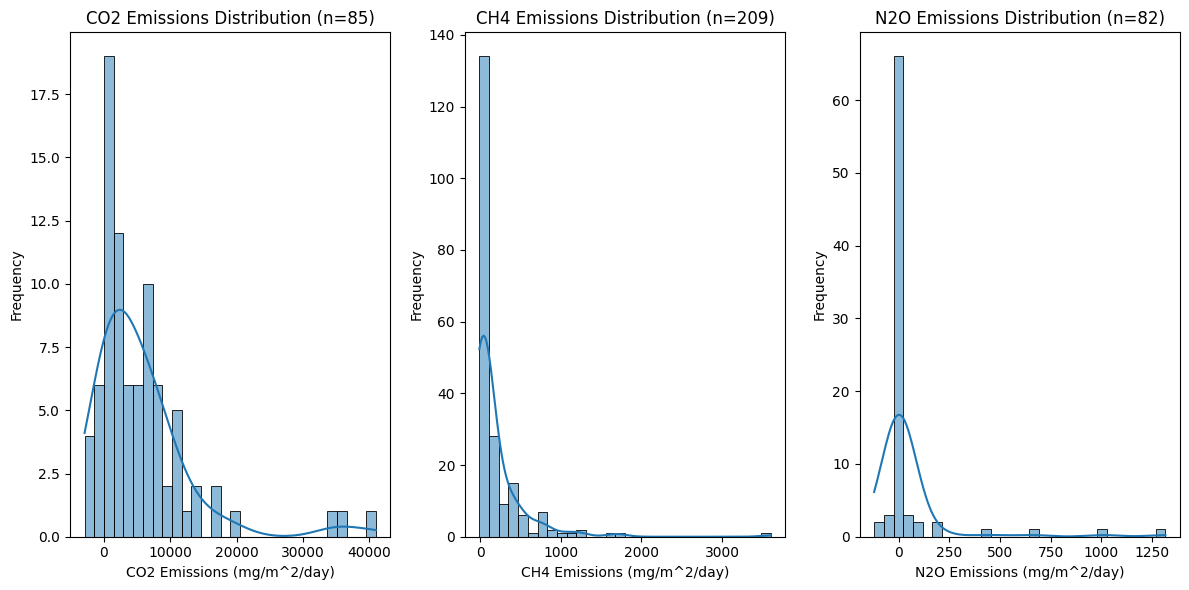

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for each GHG type
co2_data = df[df['GHG_Type'] == 'CO2']['Flux_Value']
ch4_data = df[df['GHG_Type'] == 'CH4']['Flux_Value']
n2o_data = df[df['GHG_Type'] == 'N2O']['Flux_Value']

# Calculate the counts for each GHG type
co2_count = co2_data.shape[0]
ch4_count = ch4_data.shape[0]
n2o_count = n2o_data.shape[0]

# Calculate the number of outliers for each GHG type
co2_outliers = calculate_outliers(df[df['GHG_Type'] == 'CO2']['Flux_Value'])
ch4_outliers = calculate_outliers(df[df['GHG_Type'] == 'CH4']['Flux_Value'])
n2o_outliers = calculate_outliers(df[df['GHG_Type'] == 'N2O']['Flux_Value'])

# Plot histograms
plt.figure(figsize=(12, 6))

# CO2
plt.subplot(1, 3, 1)
sns.histplot(co2_data, bins=30, kde=True)
plt.title(f'CO2 Emissions Distribution (n={co2_count})')
plt.xlabel('CO2 Emissions (mg/m^2/day)')
plt.ylabel('Frequency')

# CH4
plt.subplot(1, 3, 2)
sns.histplot(ch4_data, bins=30, kde=True)
plt.title(f'CH4 Emissions Distribution (n={ch4_count})')
plt.xlabel('CH4 Emissions (mg/m^2/day)')
plt.ylabel('Frequency')

# N2O
plt.subplot(1, 3, 3)
sns.histplot(n2o_data, bins=30, kde=True)
plt.title(f'N2O Emissions Distribution (n={n2o_count})')
plt.xlabel('N2O Emissions (mg/m^2/day)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Insights from GHG Emissions Distribution

The histograms with KDE plots for CO2, CH4, and N2O emissions reveal that all three greenhouse gases exhibit a **right-skewed distribution**, indicating that most emissions are concentrated at the lower end of the scale, with a few extreme high values. **CO2 emissions** show a broad distribution with a majority of values below 10,000 mg/m^2/day, while **CH4 emissions** have a very high frequency of low values near zero, suggesting that CH4 emissions are generally low but can occasionally spike. **N2O emissions** are predominantly close to zero, with very few high emission instances. These patterns suggest that while **typical emissions are low**, certain conditions can lead to **significant emission spikes**.


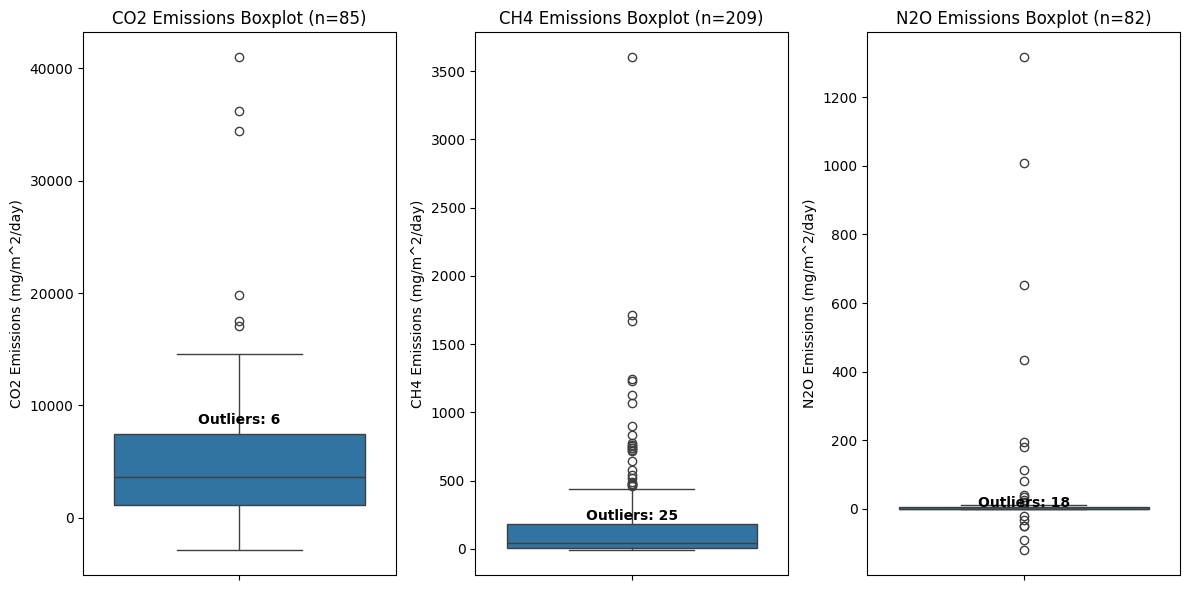

In [60]:
# Create a boxplot for each GHG type to check for outliers
plt.figure(figsize=(12, 6))

# CO2
plt.subplot(1, 3, 1)
sns.boxplot(y=df[df['GHG_Type'] == 'CO2']['Flux_Value'])
plt.title(f'CO2 Emissions Boxplot (n={co2_count})')
plt.ylabel('CO2 Emissions (mg/m^2/day)')
plt.text(0, co2_data.quantile(0.75) + 1.5 * (co2_data.quantile(0.75) - co2_data.quantile(0.25)) * 0.1, f'Outliers: {co2_outliers}',
         horizontalalignment='center', size='medium', color='black', weight='semibold')

# CH4
plt.subplot(1, 3, 2)
sns.boxplot(y=df[df['GHG_Type'] == 'CH4']['Flux_Value'])
plt.title(f'CH4 Emissions Boxplot (n={ch4_count})')
plt.ylabel('CH4 Emissions (mg/m^2/day)')
plt.text(0, ch4_data.quantile(0.75) + 1.5 * (ch4_data.quantile(0.75) - ch4_data.quantile(0.25)) * 0.1, f'Outliers: {ch4_outliers}',
         horizontalalignment='center', size='medium', color='black', weight='semibold')

# N2O
plt.subplot(1, 3, 3)
sns.boxplot(y=df[df['GHG_Type'] == 'N2O']['Flux_Value'])
plt.title(f'N2O Emissions Boxplot (n={n2o_count})')
plt.ylabel('N2O Emissions (mg/m^2/day)')
plt.text(0, n2o_data.quantile(0.75) + 1.5 * (n2o_data.quantile(0.75) - n2o_data.quantile(0.25)) * 0.1, f'Outliers: {n2o_outliers}',
         horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.tight_layout()
plt.show()

### Insights from the Boxplots of GHG Emissions

The boxplots for CO2, CH4, and N2O emissions reveal valuable insights into the **distribution** and presence of **outliers**. CO2 emissions have 6 outliers, indicating occasional **spikes** in emissions, with most values concentrated below 10,000 mg/m^2/day. CH4 emissions display the highest variability with 23 outliers, suggesting frequent **high emission events** and a narrow IQR reflecting low central variability. N2O emissions, while generally low, exhibit 18 outliers, pointing to conditions that lead to **substantial increases**. These outliers across all GHGs suggest that specific environmental factors may cause significant deviations in emissions.


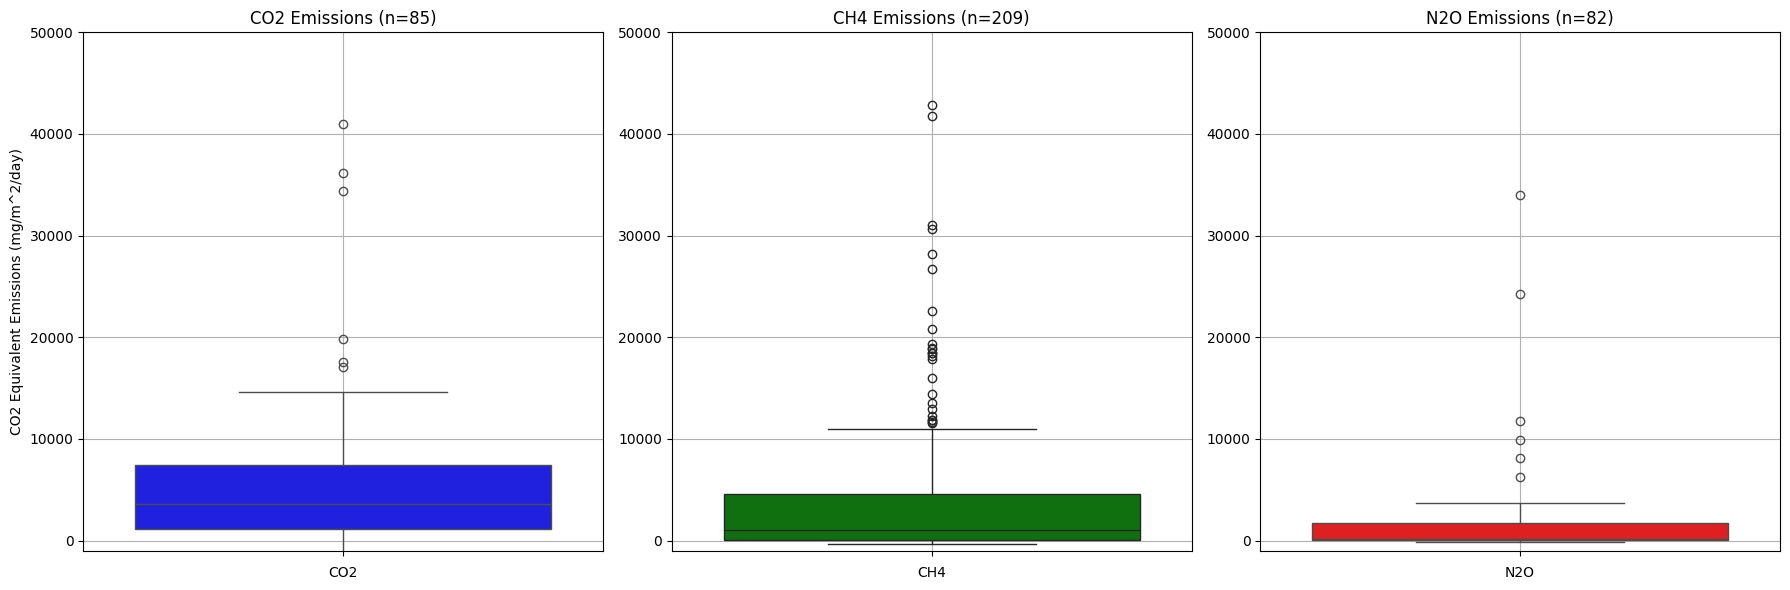

In [61]:
# Set the figure size
plt.figure(figsize=(18, 6))

# Create a common y-axis for all subplots
y_lim = (-1000, 50000)

# CO2 Boxplot
plt.subplot(1, 3, 1)
sns.boxplot(y=df[df['GHG_Type'] == 'CO2']['CO2e'], color='blue')
plt.title('CO2 Emissions (n={})'.format(df[df['GHG_Type'] == 'CO2'].shape[0]))
plt.ylabel('CO2 Equivalent Emissions (mg/m^2/day)')
plt.xlabel('CO2')
plt.ylim(y_lim)
plt.grid(True)

# CH4 Boxplot
plt.subplot(1, 3, 2)
sns.boxplot(y=df[df['GHG_Type'] == 'CH4']['CO2e'], color='green')
plt.title('CH4 Emissions (n={})'.format(df[df['GHG_Type'] == 'CH4'].shape[0]))
plt.ylabel('')
plt.xlabel('CH4')
plt.ylim(y_lim)
plt.grid(True)

# N2O Boxplot
plt.subplot(1, 3, 3)
sns.boxplot(y=df[df['GHG_Type'] == 'N2O']['CO2e'], color='red')
plt.title('N2O Emissions (n={})'.format(df[df['GHG_Type'] == 'N2O'].shape[0]))
plt.ylabel('')
plt.xlabel('N2O')
plt.ylim(y_lim)
plt.grid(True)

plt.tight_layout()
plt.show()


In [62]:
# Extract CO2e emissions for each GHG type
co2e_data = df[df['GHG_Type'] == 'CO2']['CO2e']
ch4e_data = df[df['GHG_Type'] == 'CH4']['CO2e']
n2oe_data = df[df['GHG_Type'] == 'N2O']['CO2e']

# Perform the Kruskal-Wallis H-test
stat, p = kruskal(co2e_data, ch4e_data, n2oe_data)

# Print the results
print('Kruskal-Wallis H-test:')
print('H-statistic:', stat)
print('p-value:', p)

# Interpret the results
alpha = 0.05
if p < alpha:
    print("There is a statistically significant difference between the CO2e emissions of the three GHG types.")
else:
    print("There is no statistically significant difference between the CO2e emissions of the three GHG types.")


Kruskal-Wallis H-test:
H-statistic: 22.68618419861595
p-value: 1.185107355286706e-05
There is a statistically significant difference between the CO2e emissions of the three GHG types.


In [63]:
import scikit_posthocs as sp
import pandas as pd

# Combine the data into a single DataFrame
data = pd.DataFrame({
    'CO2e': df['CO2e'],
    'GHG_Type': df['GHG_Type']
})

# Perform Dunn's test with Bonferroni correction
dunn_result = sp.posthoc_dunn(data, val_col='CO2e', group_col='GHG_Type', p_adjust='bonferroni')

# Print the results
print(dunn_result)


          CH4       CO2       N2O
CH4  1.000000  0.006715  0.025733
CO2  0.006715  1.000000  0.000006
N2O  0.025733  0.000006  1.000000


### Insights from the CO2 Equivalent Emissions Boxplots

The boxplots of CO2 equivalent (CO2e) emissions for CO2, CH4, and N2O provide several key insights. The **median CO2e emissions** for CO2, CH4, and N2O are visibly different, with CH4 and N2O having a lower median CO2e emission compared to CO2. The **interquartile range (IQR)** for CH4 and N2O is much narrower than for CO2, indicating that CO2 emissions have higher variability. All three GHGs show a significant number of outliers, with CO2 outliers reaching up to approximately 40,000 mg/m^2/day. CH4 and N2O also have several high-value outliers, but these are less extreme compared to CO2. The Dunn’s test results show statistically significant differences between the CO2e emissions of the three GHG types: **CH4 vs CO2** (p-value = 0.006715), **CH4 vs N2O** (p-value = 0.025733), and **CO2 vs N2O** (p-value = 0.000006). These p-values indicate that there are **significant differences** between the CO2e emissions for each pair of GHGs, with the most significant difference observed between CO2 and N2O. The CO2 equivalent (CO2e) emissions data demonstrates that **CO2 has the highest median emissions and the greatest variability**. The presence of numerous outliers across all three GHGs indicates that there are conditions under which emissions can spike dramatically. The statistical tests confirm that these differences in emissions are significant, suggesting that each GHG type behaves differently in terms of CO2e emissions. Given these insights, the next step involves exploring whether the **technique used to measure the gas** has any impact on the observed emissions. This analysis will help in understanding if measurement techniques contribute to the variability and differences observed in CO2e emissions across different GHG types.


## 2.2 Impact of Measurement Techniques on GHG Emissions


In [64]:
df['Equipment'].unique()

array(['Static Chambers', 'Eddy Covariance Systems', 'Polyethylene Bags',
       'Vials', 'Portable Gas Flux Systems', 'Floating Chambers',
       'Dynamic Chambers'], dtype=object)

In [65]:
co2_data = df[df['GHG_Type'] == 'CO2']
ch4_data = df[df['GHG_Type'] == 'CH4']
n2o_data = df[df['GHG_Type'] == 'N2O']

### CO2

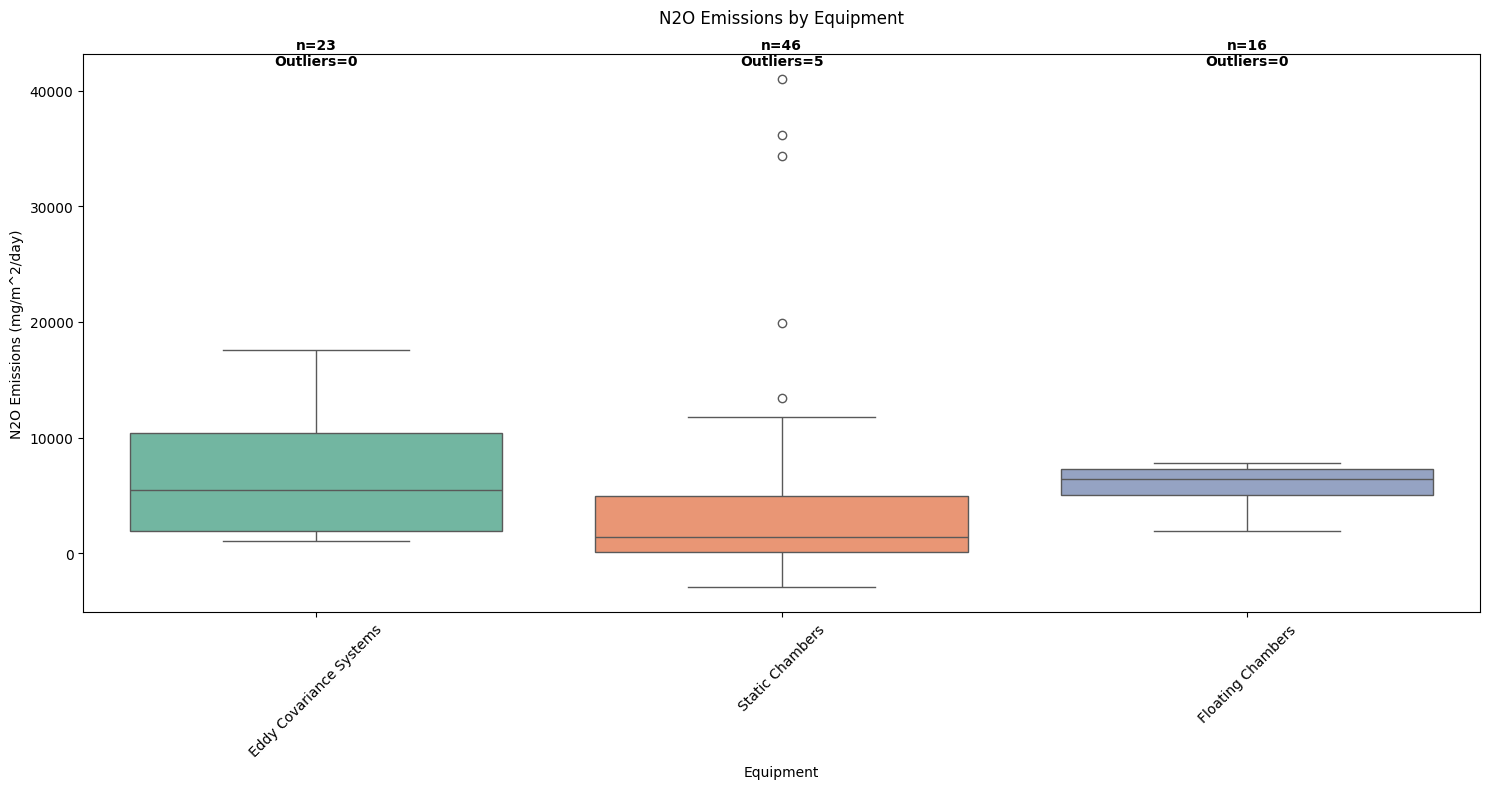

Kruskal-Wallis H Test: Statistic=12.461746701181099, p-value=0.0019677326255352107


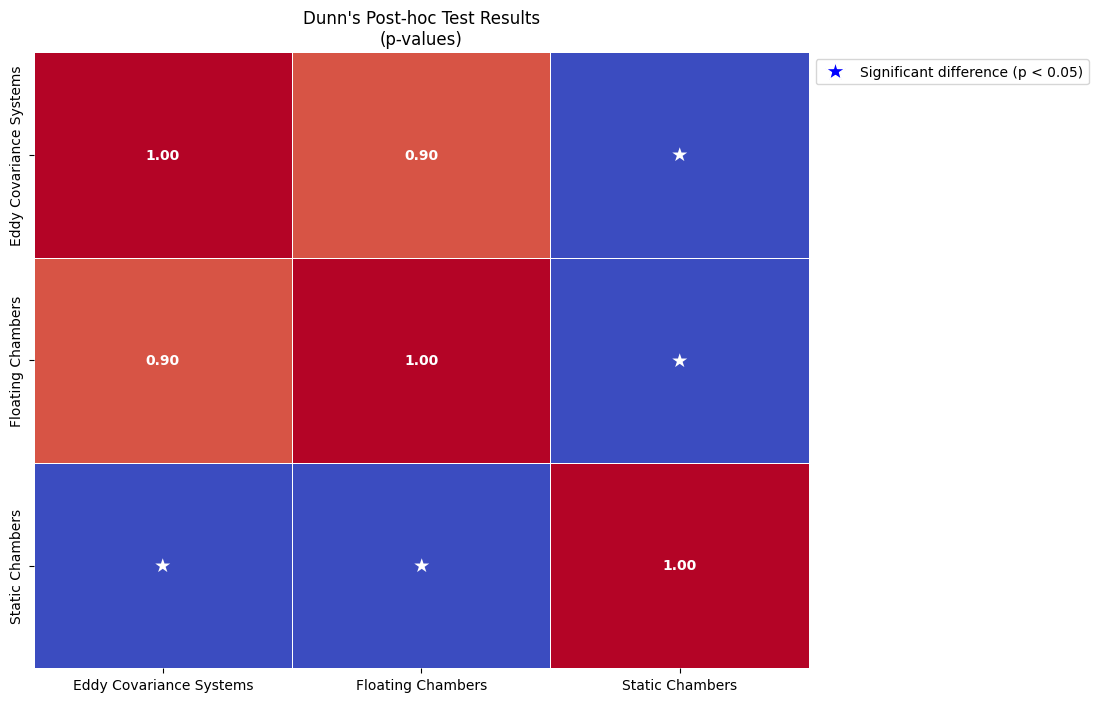

In [66]:
create_boxplot_and_stats(df = co2_data, value_column = 'Flux_Value', category_column = 'Equipment', y_label = 'N2O Emissions (mg/m^2/day)', title_prefix = 'N2O Emissions')


The analysis of CO2 emissions by measurement technique reveals several key insights. **Static Chambers** exhibit the highest variability and the most outliers, indicating a broad range of emission conditions, including extreme values. In contrast, **Eddy Covariance Systems** show moderate variability with a higher median CO2 emission, capturing more typical emission conditions without as many extremes. **Floating Chambers** display the least variability and lower median emissions, suggesting they might provide more consistent measurements but potentially underestimate higher emission events. Statistical analysis using Dunn's test indicates significant differences between Static Chambers and both Eddy Covariance Systems and Floating Chambers, but no significant difference between Eddy Covariance Systems and Floating Chambers. These findings highlight the importance of selecting appropriate measurement techniques for CO2 emission studies, as different methods can yield significantly different results. For the next section, it would be valuable to explore whether similar patterns hold for other greenhouse gases, such as CH4 and N2O, to see if the measurement technique consistently influences emissions across different gases.


### CH4

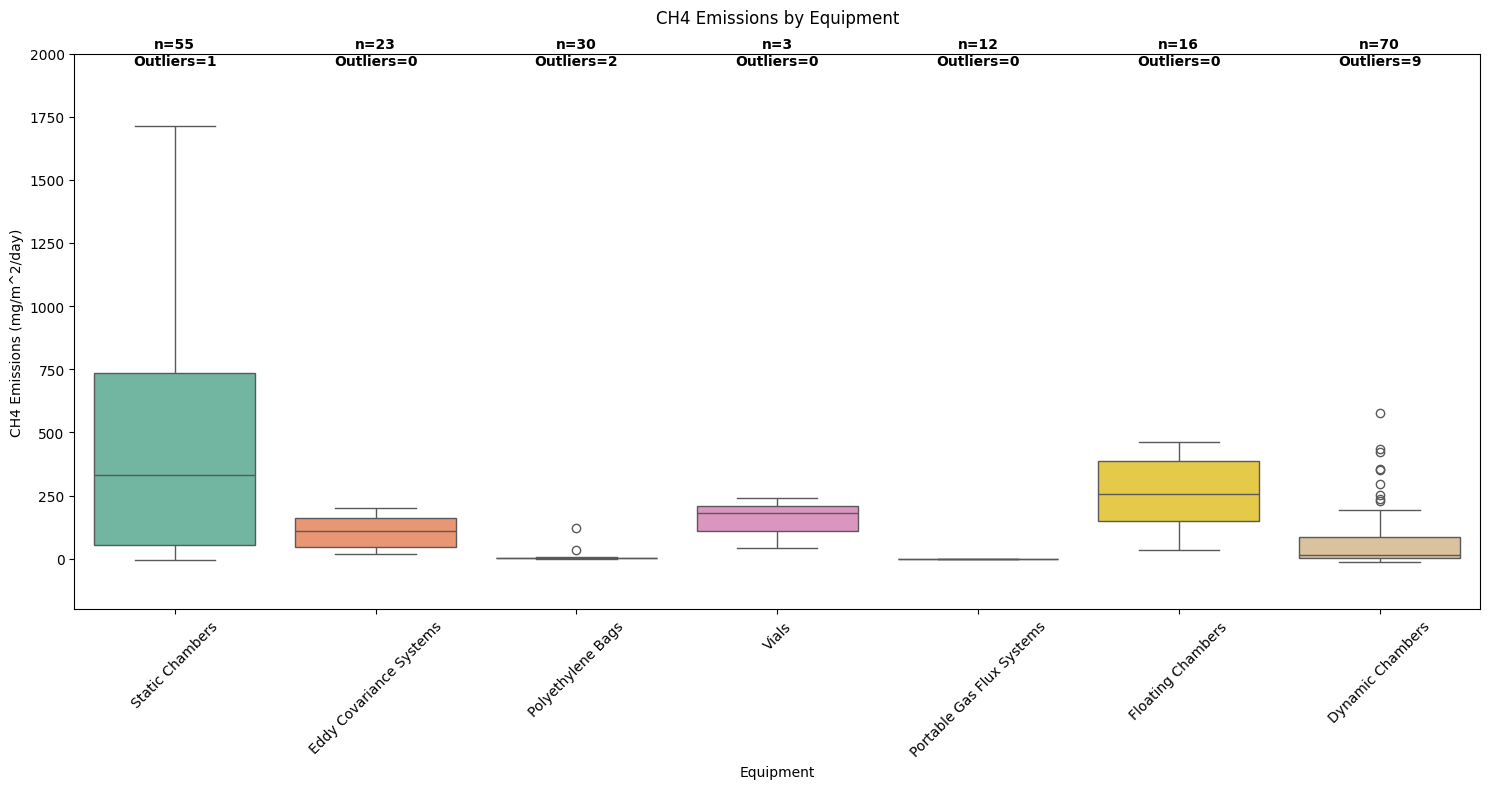

😔 Excluded from analysis due to small sample size: ['Vials']
Kruskal-Wallis H Test: Statistic=99.0994821128702, p-value=8.181377009511486e-20


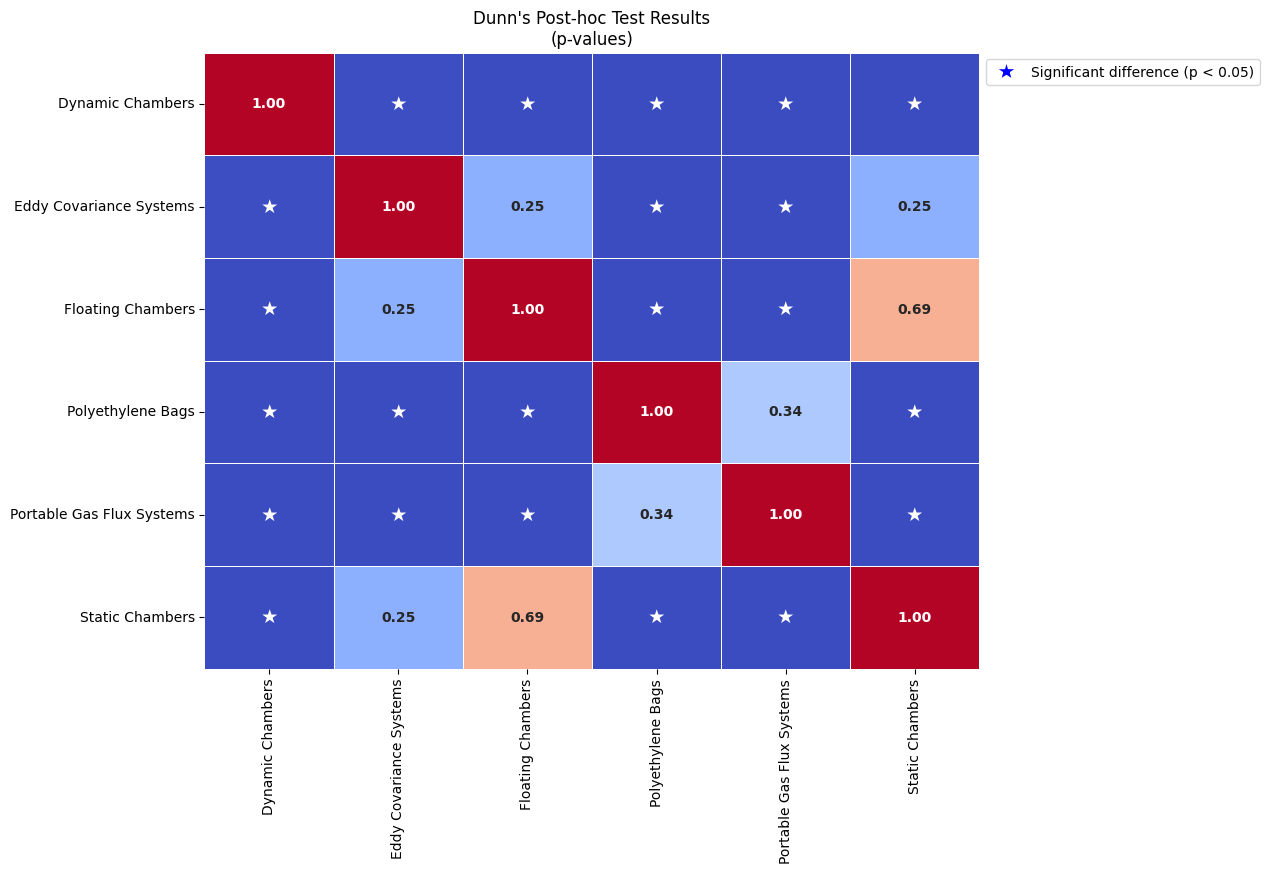

In [67]:
create_boxplot_and_stats(df = ch4_data, value_column = 'Flux_Value', category_column = 'Equipment', y_label = 'CH4 Emissions (mg/m^2/day)', title_prefix = 'CH4 Emissions', min_sample_size=10, y_limits=(-200, 2000))

The analysis reveals that there is a **high variation in emissions measured using static chambers**, indicating potential methodological inconsistencies or environmental factors influencing the measurements. Conversely, the **low variation observed in polyethylene bags and portable gas flux systems** might be due to the data originating from a single study or article for each method, leading to more consistent measurements. **Significant differences (p < 0.05) between various measurement techniques**, as indicated by Dunn's post-hoc test, suggest that the choice of method can impact recorded CH4 emissions. However, it is essential to consider other influencing factors such as environmental conditions, site-specific characteristics, and study design. The results underscore the need for **cautious interpretation of the method influence on emissions**, emphasizing the importance of accounting for a broad range of variables. Moving forward, it would be beneficial to investigate other influencing factors by filtering the data by equipment type and examining variables like vegetation type, substrate type, season, and operational period. This approach will help isolate the effect of each factor, providing a more nuanced understanding of their influence on GHG emissions.


### N2O

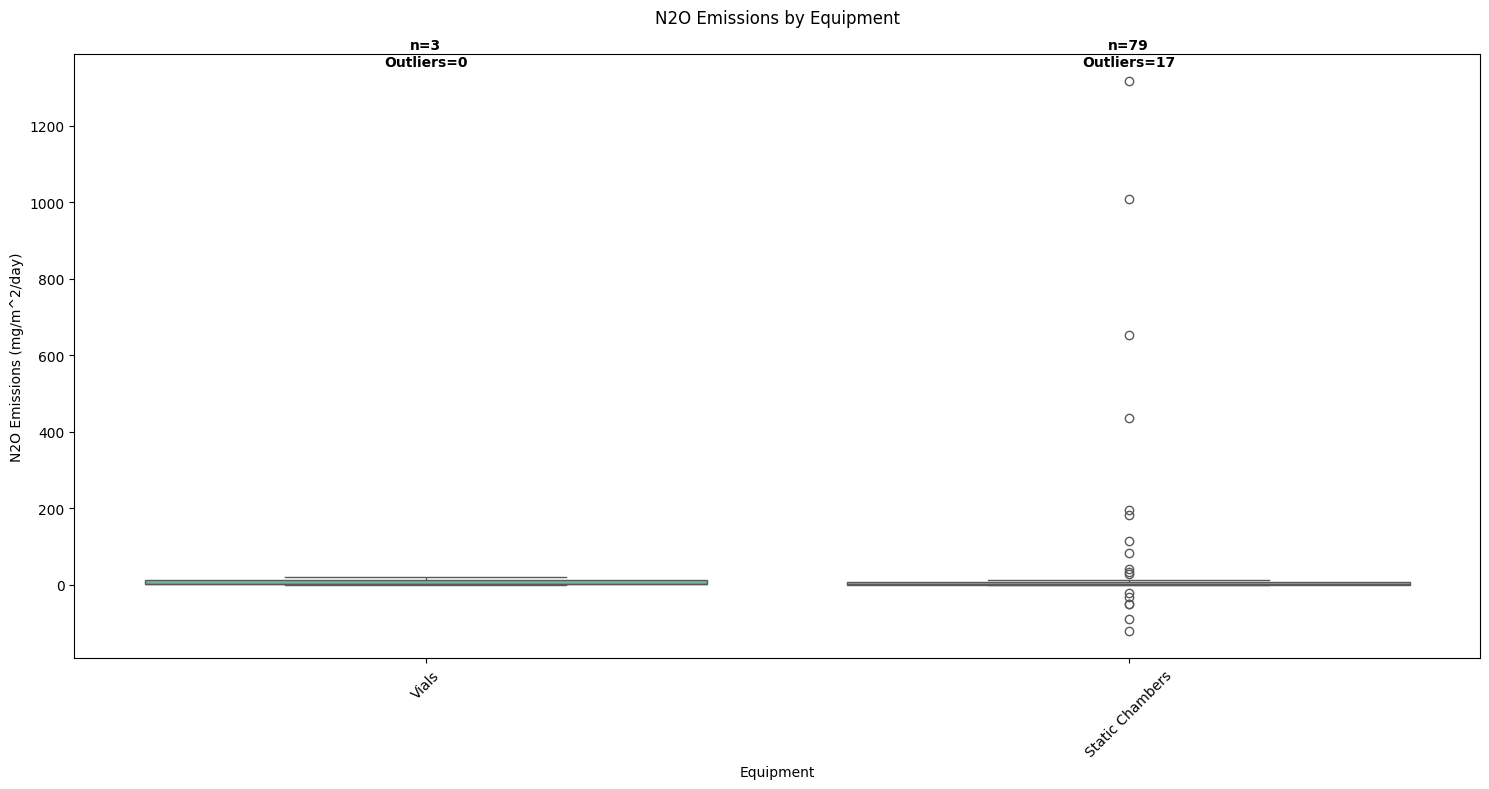

Kruskal-Wallis H Test: Statistic=0.11119704622060224, p-value=0.738785409850581
No significant difference found by Kruskal-Wallis test.


In [68]:
create_boxplot_and_stats(df = n2o_data, value_column = 'Flux_Value', category_column = 'Equipment', y_label = 'N2O Emissions (mg/m^2/day)', title_prefix = 'N2O Emissions', min_sample_size=1, y_limits=None)

The plot of **N2O emissions by equipment type** shows significant variability in measurements taken with **static chambers**, with many outliers present. This high variability reinforces the idea that other factors besides the measurement method might influence the emissions. The vials method, with a small sample size, shows no variability, which limits the reliability of this comparison. To gain further insights, it is crucial to filter the data and focus on **chamber-based methods** (**static, floating, and dynamic chambers**) and investigate the impact of other factors such as **soil type, water content, vegetation type, season, and operational conditions** on N2O emissions. This approach will help identify the specific factors contributing to the variability within a more controlled subset of data. **Note**: The sample size for the vials method is very small (**n=3**), limiting the reliability of the comparison.


## 2.3 Impact of Seasons on GHG Emissions
**Note**: From this point forward, the analysis will be **filtered by the type of greenhouse gas (GHG)** and the use of **chamber-based measurement techniques** (static, floating, and dynamic chambers) to measure the GHG emissions. This focused approach will help control for variability and isolate the impact of other environmental and operational factors on emissions.


In [69]:
# Filter the dataset for CO2 emissions and chamber-based measurements
co2_chamber_data = co2_data[co2_data['Equipment'].isin(['Static Chambers', 'Floating Chambers', 'Dynamic Chambers'])]

# Filter the dataset for CH4 emissions and chamber-based measurements
ch4_chamber_data = ch4_data[ch4_data['Equipment'].isin(['Static Chambers', 'Floating Chambers', 'Dynamic Chambers'])]

# Filter the dataset for N2O emissions and chamber-based measurements
n2o_chamber_data = n2o_data[n2o_data['Equipment'].isin(['Static Chambers', 'Floating Chambers', 'Dynamic Chambers'])]


### CO2

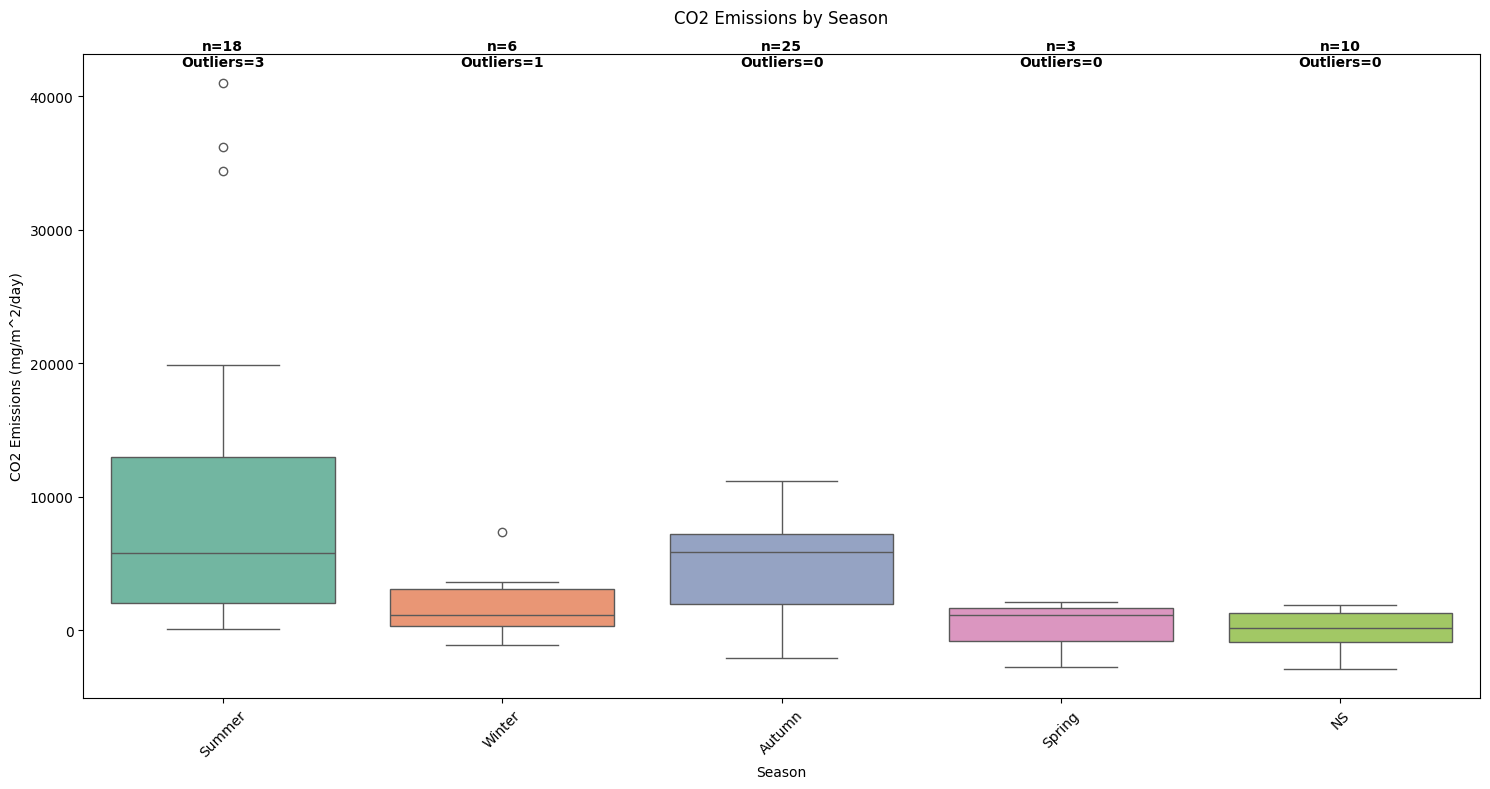

😔 Excluded from analysis due to small sample size: ['Winter', 'Spring']
Kruskal-Wallis H Test: Statistic=15.263796878639653, p-value=0.00048473973529556796


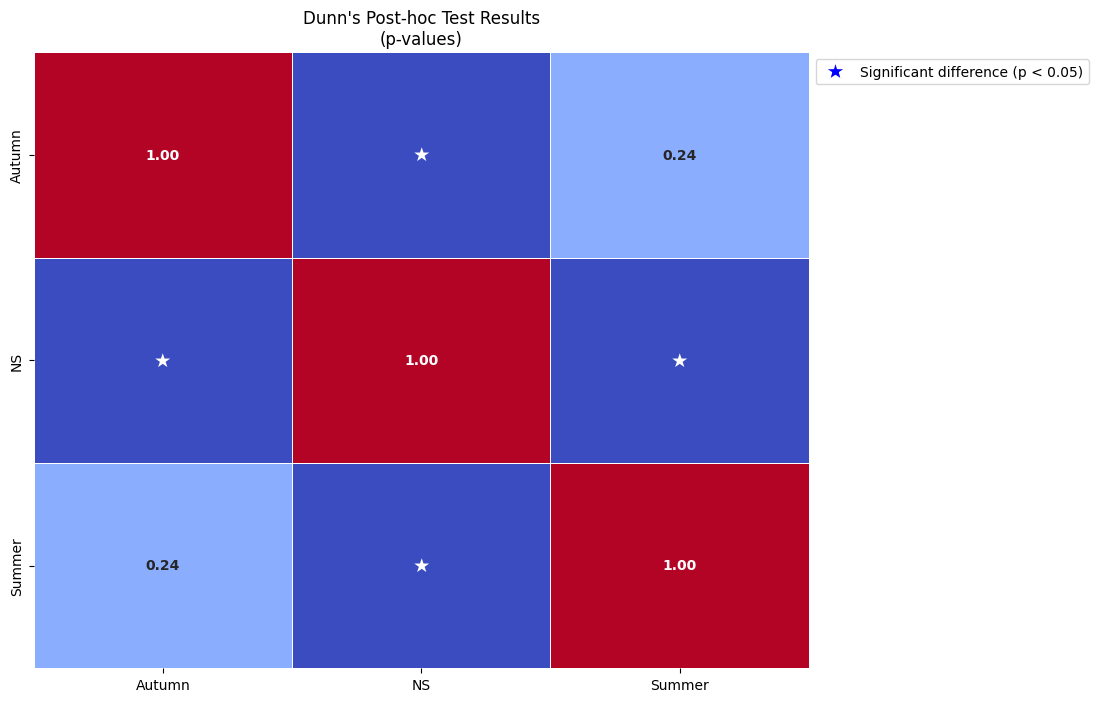

In [70]:
create_boxplot_and_stats(df = co2_chamber_data, value_column = 'Flux_Value', category_column = 'Season', y_label = 'CO2 Emissions (mg/m^2/day)', title_prefix = 'CO2 Emissions', min_sample_size=10, y_limits=None)


The Kruskal-Wallis test found no statistically significant difference in **CO2 emissions** between different seasons, including **summer and winter**. Despite the visual differences in the boxplots, the high variability within each season and the presence of outliers, especially in summer, suggest that seasonal changes may not strongly influence **CO2 emissions** in constructed wetlands. Additionally, the relatively small sample sizes for each season might affect the power of the statistical test to detect significant differences.

There is no reliable way to do a comparison when including **winter and spring** because the sample size is not big enough. Among **summer and autum**, there was not a huge difference, and the statistical analysis shows that there is no significant difference. Therefore, I might investigate the temperatures using an API to retrieve the temperatures around this time and at the specific latitude and longitude.


### CH4

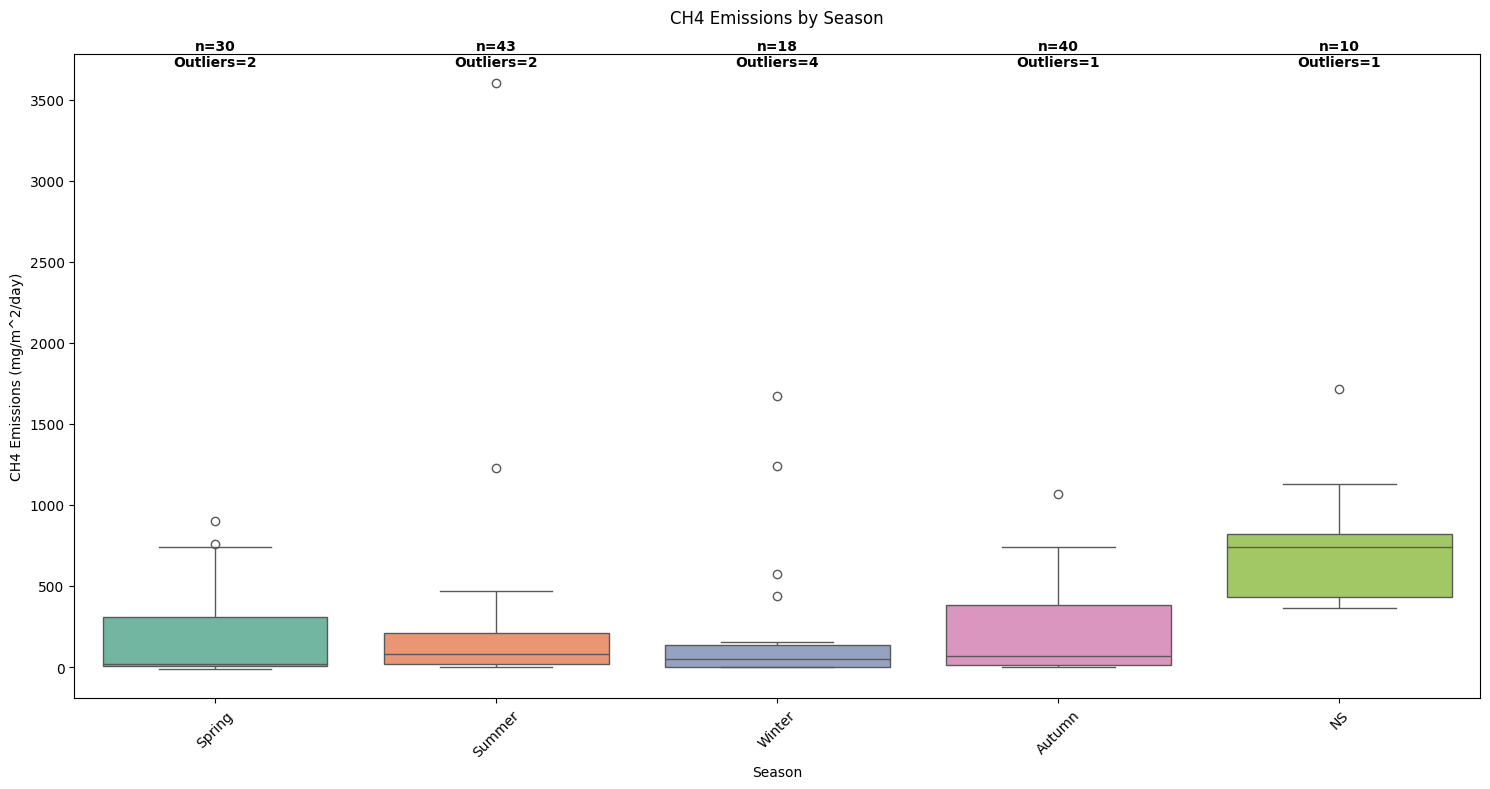

Kruskal-Wallis H Test: Statistic=20.426079257553194, p-value=0.00041139272059760926


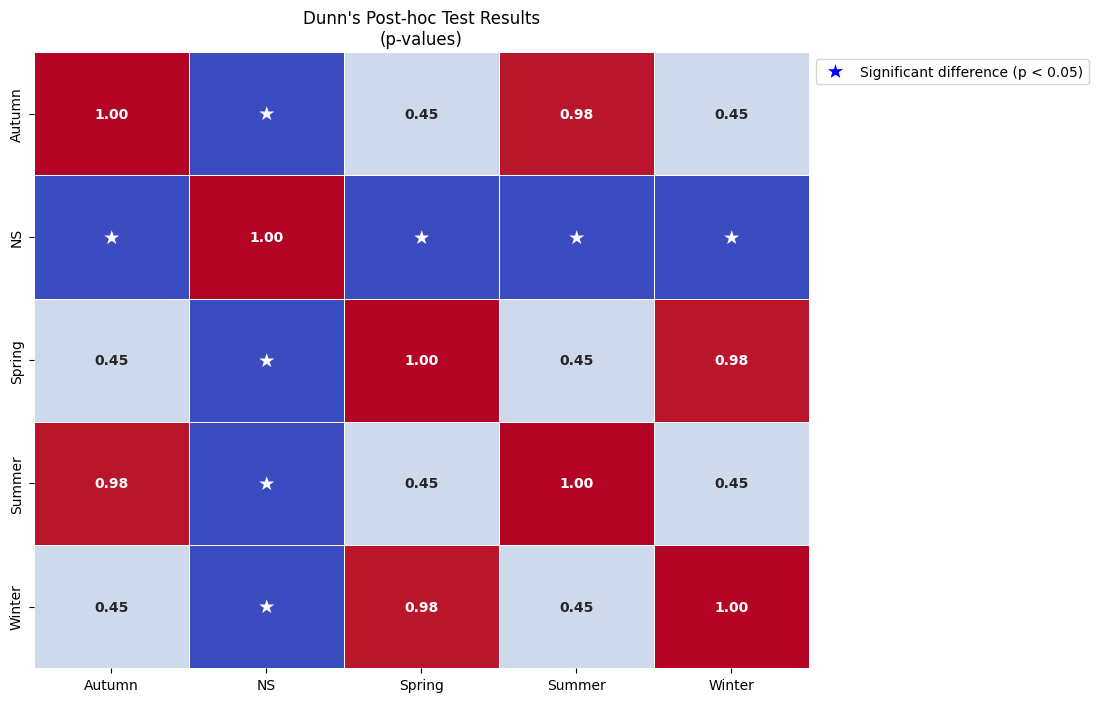

In [71]:
create_boxplot_and_stats(df = ch4_chamber_data, value_column = 'Flux_Value', category_column = 'Season', y_label = 'CH4 Emissions (mg/m^2/day)', title_prefix = 'CH4 Emissions', min_sample_size=1, y_limits=None)


The boxplot reveals that **CH4 emissions** across different seasons do not show significant variations. This observation is supported by the statistical analysis, indicating no substantial differences between the seasons. The median CH4 emissions are relatively consistent across all seasons, with some slight variations but no pronounced differences. This suggests that **CH4 emissions** might not be strongly influenced by seasonal changes. Although outliers are present in all seasons, their impact does not seem significant enough to create statistical differences, implying that occasional spikes in CH4 emissions do not follow a seasonal pattern.

The absence of significant seasonal differences in CH4 emissions is intriguing and warrants further investigation. It may be necessary to explore other environmental factors or mechanisms that could be influencing **CH4 emissions**, such as **temperature, moisture levels, or microbial activity**. Additionally, the **operational period** of the wetland and the type of **vegetation** present might play a more significant role in influencing **CH4 emissions** than the season itself. By focusing on these factors, we could gain a better understanding of the underlying mechanisms driving **CH4 emissions** in constructed wetlands.


### N2O

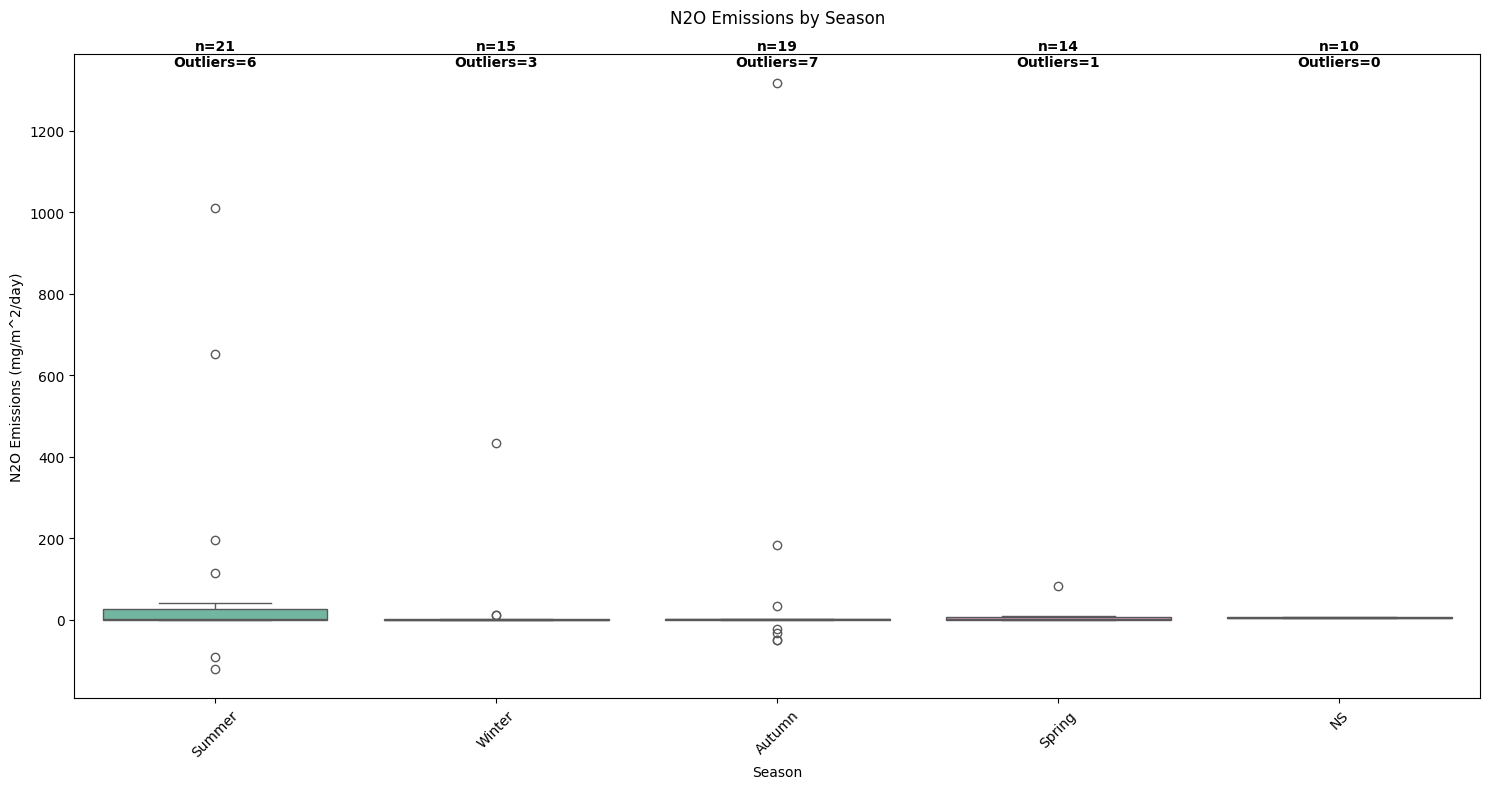

Kruskal-Wallis H Test: Statistic=9.357868650566052, p-value=0.05275109603428018
No significant difference found by Kruskal-Wallis test.


In [72]:
create_boxplot_and_stats(df = n2o_chamber_data, value_column = 'Flux_Value', category_column = 'Season', y_label = 'N2O Emissions (mg/m^2/day)', title_prefix = 'N2O Emissions', min_sample_size=1, y_limits=None)

The above analysis indicates no significant difference in **N2O emissions** across different seasons. This lack of variation suggests that other factors might be influencing **N2O emissions** in constructed wetlands. It's noteworthy that the number of outliers varies among the seasons, with **Summer** showing the highest number of outliers. This could indicate occasional spikes in emissions during the summer months, but the overall trend remains consistent across seasons. Given the absence of significant seasonal variation, the next step is to investigate the impact of vegetation presence on **N2O emissions**. Vegetation can play a crucial role in greenhouse gas emissions by influencing soil properties and microbial activities. Therefore, comparing emissions with and without vegetation will provide valuable insights. Additionally, leveraging an API to retrieve climate variables such as **temperature** and **moisture levels** for the specific latitudes and longitudes of each wetland measurement is essential. These climate variables may have a substantial impact on emissions and could help explain the observed patterns. By incorporating these additional factors, we aim to gain a deeper understanding of the mechanisms driving **greenhouse gas emissions** in constructed wetlands and identify potential mitigation strategies.



## 2.4 Impact of Vegetation on GHG Emissions  
**Note:** The classification of "plant" or "no plant" is based on the presence of plants inside the chamber during the measurements. Some studies included plants within the chamber, while others did not. This classification does not refer to the presence or absence of plants in the wetland as a whole, but specifically to the conditions within the measurement chamber.


### CO2

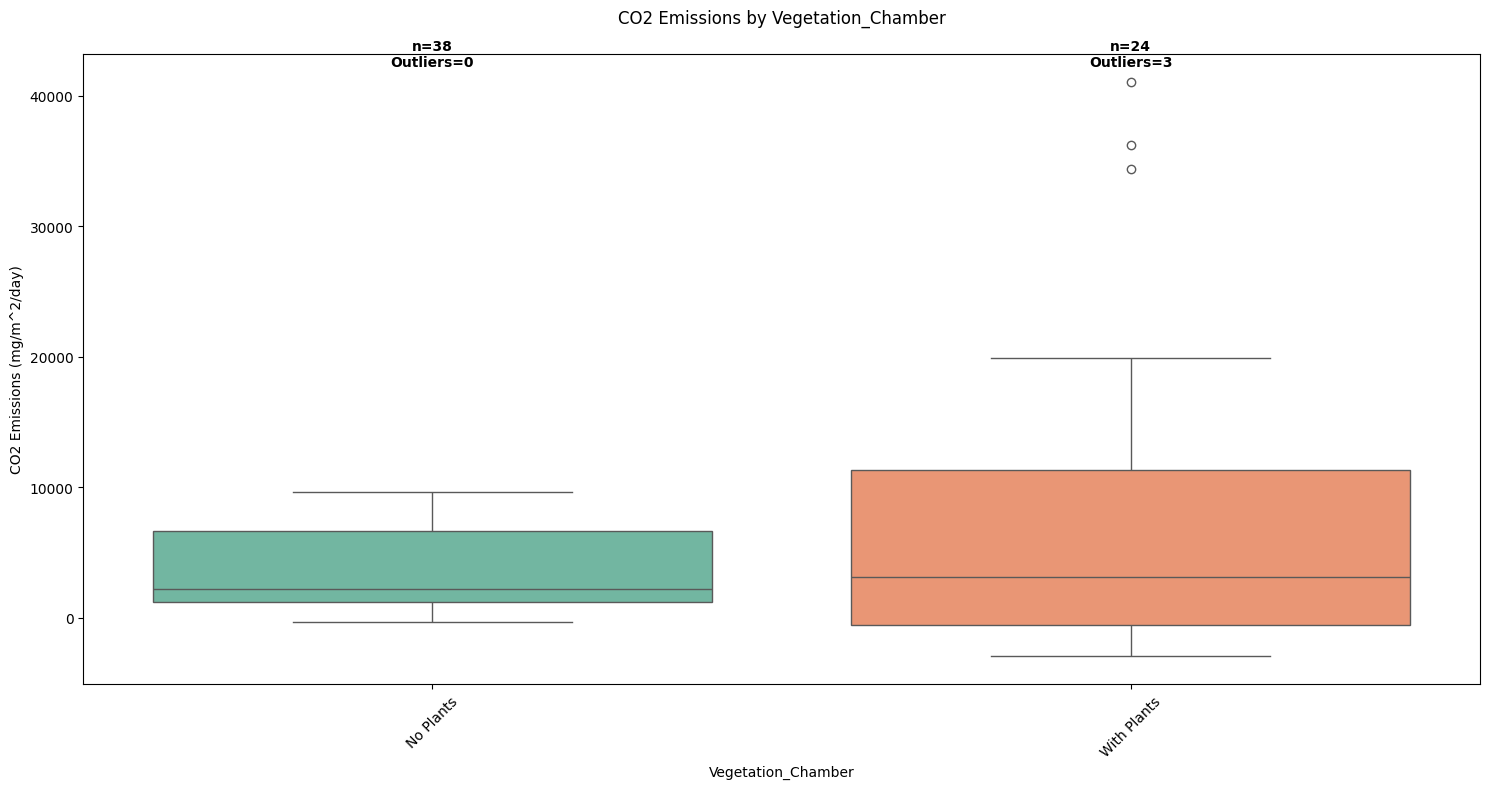

Kruskal-Wallis H Test: Statistic=0.030075187969941908, p-value=0.8623197383893976
No significant difference found by Kruskal-Wallis test.


In [73]:
create_boxplot_and_stats(df = co2_chamber_data, value_column = 'Flux_Value', category_column = 'Vegetation_Chamber', y_label = 'CO2 Emissions (mg/m^2/day)', title_prefix = 'CO2 Emissions', min_sample_size=10, y_limits=None)

In [74]:
unique_values = co2_chamber_data['Vegetation_Chamber'].unique()
print(unique_values)

['No Plants' 'With Plants']


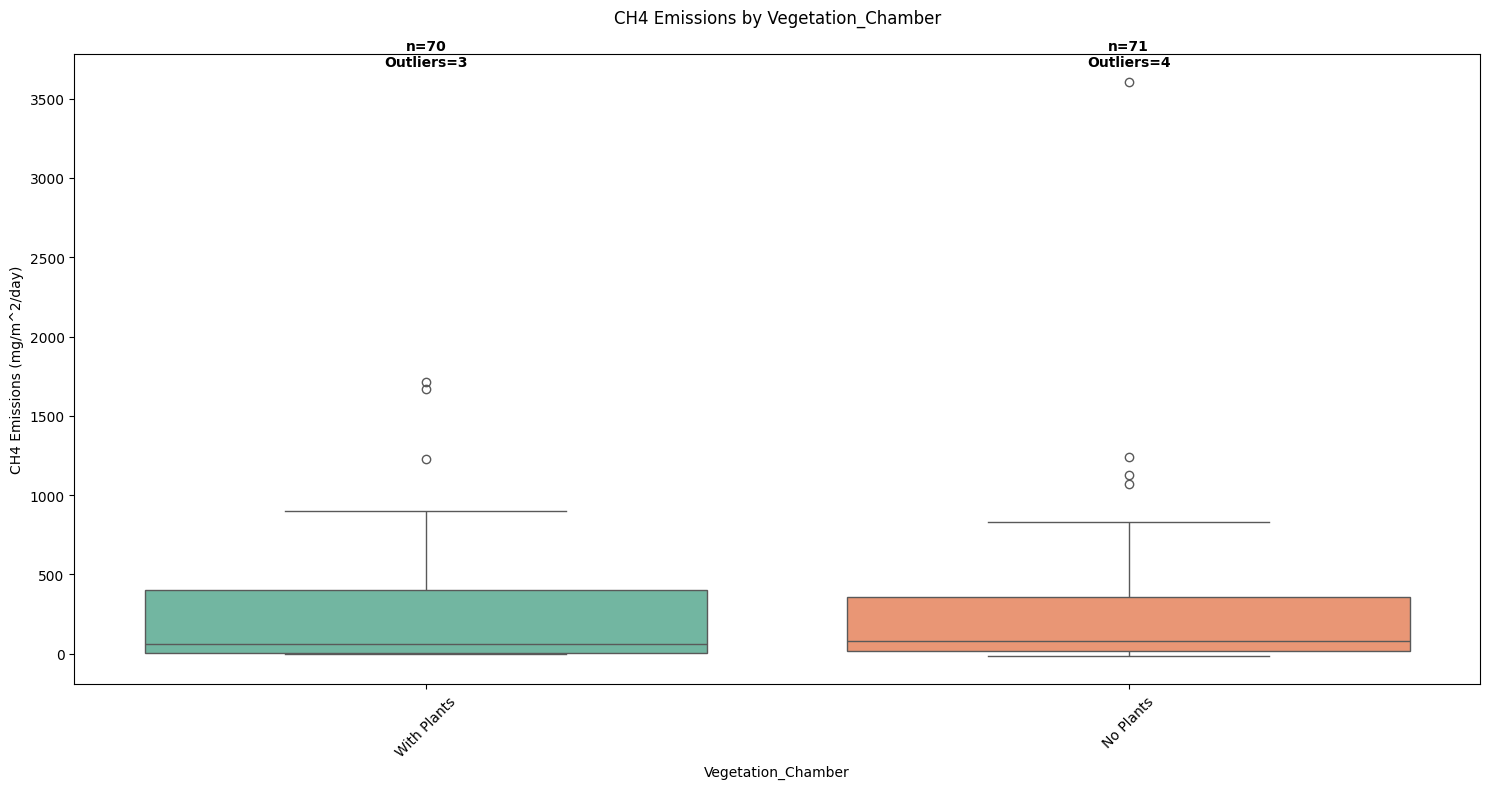

Kruskal-Wallis H Test: Statistic=0.8646489753882263, p-value=0.3524409707093188
No significant difference found by Kruskal-Wallis test.


In [75]:
create_boxplot_and_stats(df = ch4_chamber_data, value_column = 'Flux_Value', category_column = 'Vegetation_Chamber', y_label = 'CH4 Emissions (mg/m^2/day)', title_prefix = 'CH4 Emissions', min_sample_size=10, y_limits=None)

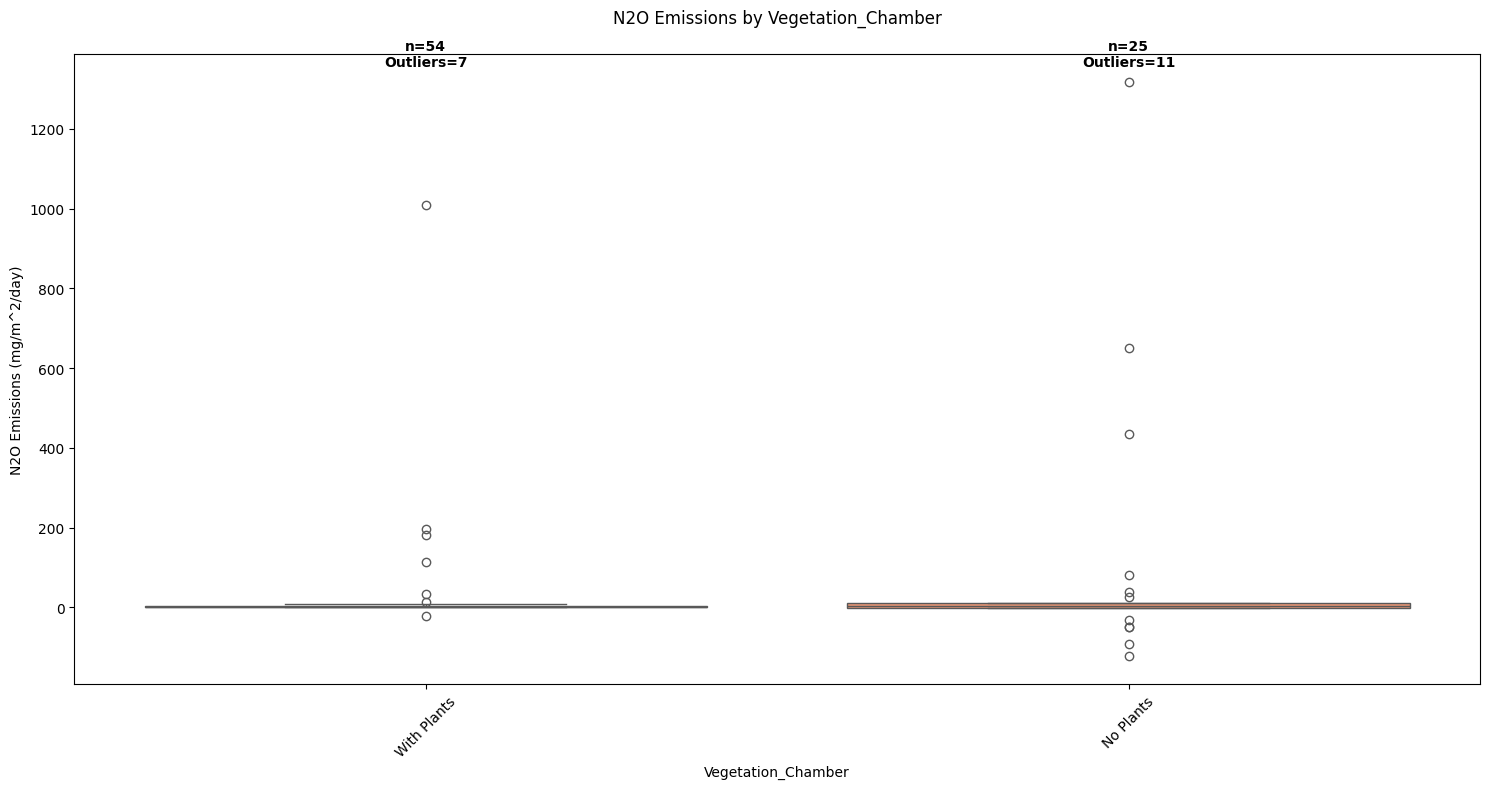

Kruskal-Wallis H Test: Statistic=0.016002921662904273, p-value=0.8993340477302887
No significant difference found by Kruskal-Wallis test.


In [77]:
create_boxplot_and_stats(df = n2o_chamber_data, value_column = 'Flux_Value', category_column = 'Vegetation_Chamber', y_label = 'N2O Emissions (mg/m^2/day)', title_prefix = 'N2O Emissions', min_sample_size=10, y_limits=None)